Importing packages

In [2]:
import scipy.integrate as scint
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Iterable
flint = float | int
interval_t = tuple[flint, flint] | Iterable[flint]

Simulation function

In [3]:
def execute_simulation(f,
                       u0: Iterable[flint],
                       coeffs: Iterable[flint],
                       time_bound: Optional[flint] = 50,
                       offsets: Optional[str | flint | Iterable[Optional[str | flint]]] = 1,
                       offsets_intervals: Optional[interval_t | Iterable[interval_t]] = (0.75, 1.25),
                       offsets_scale: Optional[int] = 100,
                       time_resolution: Optional[int | str] = "auto",
                       iter_total: Optional[int] = 1):
    rng = np.random.default_rng()

    # declare some lists
    u0_list = []
    coeffs_list = []
    sol_list = []

    # declare the total number of parameters
    total_length = len(u0) + len(coeffs)

    # handle default values and declare total_length.
    # also make sure this function is effectively pass-by-value.
    time_bound_default = 50
    offsets_default = 1
    individual_offset_default = 1
    offsets_intervals_default = (0.75, 1.25)
    offsets_scale_default = 100
    time_resolution_default = "auto"
    iter_total_default = 1

    u0_base = u0
    coeffs_base = coeffs
    time_bound_base = time_bound_default if time_bound is None else time_bound
    offsets_base = offsets_default if offsets is None else offsets
    offsets_intervals_base = offsets_intervals_default if offsets_intervals is None else offsets_intervals
    offsets_scale_base = offsets_scale_default if offsets_scale is None else offsets_scale
    time_resolution_base = time_resolution_default if time_resolution is None else time_resolution
    iter_total_base = iter_total_default if iter_total is None else iter_total

    u0_base = [item for item in u0_base].copy()
    coeffs_base = [item for item in coeffs_base].copy()
    offsets_base = ["random" for i in range(total_length)] if offsets_base == "random" else offsets_base
    if isinstance(offsets_base, str):
        raise ValueError("`offsets` must be either \"random\" or a non-string, which is violated here.")
    offsets_base = [offsets_base for i in range(total_length)] if isinstance(offsets_base, flint) else offsets_base
    offsets_base = [individual_offset_default if item is None else item for item in offsets_base]
    if any([isinstance(item, str) and item != "random" for item in offsets_base]):
        raise ValueError("entries of `offsets` must be either \"random\" or non-strings, which is violated here.")
    if len(offsets_intervals_base) == 2 and isinstance(offsets_intervals_base[0], flint):
        offsets_intervals_base = [[item for item in offsets_intervals_base] for i in range(total_length)]
    offsets_intervals_base = [tuple([value for value in item]) for item in offsets_intervals_base]
    if any([(not isinstance(item, tuple)) or len(item) != 2 for item in offsets_intervals_base]):
        raise ValueError("either `offsets_intervals` or an entry thereof is not a 2-tuple, which is not allowed.")
    if any([any([not isinstance(value, flint) for value in item]) for item in offsets_intervals_base]):
        raise ValueError("`offsets_intervals` does not describe one or more numeric intervals, which is not allowed.")
    if isinstance(time_resolution_base, str) and time_resolution_base != "auto":
        raise ValueError("`time_resolution` must be either \"auto\" or a non-string, which is violated here.")

    # run simulations
    for n in range(iter_total_base):
        # randomize starting values and parameters just a little bit if the user wants that
        transposable = np.array(offsets_intervals_base) * offsets_scale_base
        offsets_intervals_low, offsets_intervals_high = np.transpose(transposable)
        offsets_random = rng.integers(offsets_intervals_low, offsets_intervals_high, total_length) / offsets_scale
        modified_offsets = [offsets_random[i] if offsets_base[i] == "random" else offsets_base[i]
                            for i in range(total_length)]

        modified_u0 = list(np.array(u0_base) * np.array(modified_offsets[0:len(u0_base)]))
        print(f"{modified_u0=}")
        modified_coeffs = list(np.array(coeffs_base) * np.array(modified_offsets[len(u0_base):total_length]))
        print(f"{modified_coeffs=}")
        u0_list.append(modified_u0.copy())
        coeffs_list.append(modified_coeffs.copy())

        trb = time_resolution_base

        t_span_input = (0, time_bound_base)
        y0_input = modified_u0
        args_input = (modified_coeffs,)
        method_input = 'Radau'
        t_eval_input = None if trb == "auto" else np.linspace(0, time_bound_base, trb + 1)

        # try to solve the ODE problem
        try:
            sol = scint.solve_ivp(fun=f,
                                  t_span=t_span_input,
                                  y0=y0_input,
                                  method=method_input,
                                  t_eval=t_eval_input,
                                  args=args_input)
            sol_list.append(sol)
        except:
            print("fail")
            return (False, u0_base, coeffs_base, time_bound_base, time_resolution_base, iter_total_base, u0_list, coeffs_list, sol_list)
        print("success")

    # return the results
    return (True, u0_base, coeffs_base, time_bound_base, time_resolution_base, iter_total_base, u0_list, coeffs_list, sol_list)


Visualization for unreduced basis model

In [4]:

def visualize_simulation(u0_base, coeffs_base, time_bound_base, time_resolution_base, iter_total_base, u0_list, coeffs_list, sol_list):
    fig, axs = plt.subplots(3, 2, layout='constrained')
    try:
        for n in range(len(sol_list)):
            u0 = u0_list[n]
            coeffs = coeffs_list[n]
            sol = sol_list[n]
            t = sol.t
            p, q, x, y, r, s = sol.y
            p0, q0, x0, y0, r0, s0 = u0
            k1, k2, k3, k4 = coeffs
            the_label = f"u0=({p0}, {q0}, {x0}, {y0}, {r0}, {s0});\n{k1=}; {k2=}; {k3=}; {k4=}"
            axs[0, 0].plot(t, p, label=the_label)
            axs[0, 1].plot(t, q, label=the_label)
            axs[1, 0].plot(t, x, label=the_label)
            axs[1, 1].plot(t, y, label=the_label)
            axs[2, 0].plot(t, r, label=the_label)
            axs[2, 1].plot(t, s, label=the_label)
        for n in range(len(sol_list)):
            u0 = u0_list[n]
            coeffs = coeffs_list[n]
            sol = sol_list[n]
            t = sol.t
            p, q, x, y, r, s = sol.y
            p0, q0, x0, y0, r0, s0 = u0
            k1, k2, k3, k4 = coeffs
            the_label = f"u0=({p0}, {q0}, {x0}, {y0}, {r0}, {s0});\n{k1=}; {k2=}; {k3=}; {k4=}"
            axs[1, 0].plot(t, y, label=the_label, alpha=0.2)  # for comparison
            axs[1, 1].plot(t, x, label=the_label, alpha=0.2)  # for comparison
            # TODO: make the color of these lines appear in the legend too
            # TODO: make these lines appear behind the other ones, but with these colors
        axs[0, 0].set(ylabel="p")
        axs[0, 0].xaxis.set_major_formatter('')
        axs[0, 0].tick_params(axis='x', length=0)
        axs[0, 0].grid(True, linestyle='dashed')
        axs[0, 1].set(ylabel="q")
        axs[0, 1].xaxis.set_major_formatter('')
        axs[0, 1].tick_params(axis='x', length=0)
        axs[0, 1].grid(True, linestyle='dashed')
        axs[1, 0].set(ylabel="x")
        axs[1, 0].xaxis.set_major_formatter('')
        axs[1, 0].tick_params(axis='x', length=0)
        axs[1, 0].grid(True, linestyle='dashed')
        axs[1, 1].set(ylabel="y")
        axs[1, 1].xaxis.set_major_formatter('')
        axs[1, 1].tick_params(axis='x', length=0)
        axs[1, 1].grid(True, linestyle='dashed')
        axs[2, 0].set(ylabel="r", xlabel='t')
        axs[2, 0].grid(True, linestyle='dashed')
        axs[2, 1].set(ylabel="s", xlabel='t')
        axs[2, 1].grid(True, linestyle='dashed')
        p_min, p_max = axs[0, 0].get_ylim()
        q_min, q_max = axs[0, 1].get_ylim()
        x_min, x_max = axs[1, 0].get_ylim()
        y_min, y_max = axs[1, 1].get_ylim()
        r_min, r_max = axs[2, 0].get_ylim()
        s_min, s_max = axs[2, 1].get_ylim()
        axs[0, 0].set_ylim(0, 2 * u0_base[0])
        axs[0, 1].set_ylim(0, 2 * u0_base[1])
        axs[1, 0].set_ylim(min(x_min, y_min), max(x_max, y_max))
        axs[1, 1].set_ylim(min(x_min, y_min), max(x_max, y_max))
        axs[2, 0].set_ylim(r_min, r_max)
        axs[2, 1].set_ylim(s_min, s_max)
    except:
        print("graph fail")
    print("graph success")
    handles, labels = axs[2, 0].get_legend_handles_labels()
    fig.legend(handles, labels, mode='expand', loc='outside lower center')
    fig.suptitle("A graph of the base model with constant P and Q.")
    plt.show()

Select unreduced unistationary basis model

In [5]:
def f(t, u, coeffs):
    p, q, x, y, r, s = u
    k1, k2, k3, k4 = coeffs
    return np.array([
        0,
        0,
        k1 * p - k2 * q * x + k3 * x * x * y - k4 * x,
        k2 * q * x - k3 * x * x * y,
        k2 * q * x,
        k4 * x
    ])

Specify parameters for unreduced unistationary basis model

In [6]:
u0 = [0.59, 0.56, 0.83, 1.25, 0, 0]  # list of starting values of the variables; first part of the parameters.
coeffs = [0.19, 1.07, 0.85, 0.22]  # list of coefficients for reaction speeds; second part of the parameters.
time_bound = 200  # cutoff point in time to stop the simulation at, or None for the default value of 50.
offsets = None  # list of factors or single factor to scale parameters by before starting;
# factors can be a number, "random", or None;
# None leaves the corresponding parameter untouched;
# "random" randomizes the factor for the corresponding parameter at the start of every simulation
# by selecting from (a discretization of) the corresponding offset interval.
offsets_intervals = None  # list of intervals or single interval to select randomized factors from,
# or None for the default range (0.75, 1.25) for every factor;
# an interval is given as a 2-tuple with lower and upper endpoints;
offsets_scale = 100  # number of points in the discretization of an interval,
# or None for the default value of 100;
# larger values here mean numbers with many decimals in your plot legends.
iter_total = None  # number of simulations to run, or None for default value of 1.
time_resolution = None  # number of points in time to actually log the values at (not counting t=0),
# or None to let the solver itself decide for us.

Execute simulation

In [7]:
result = execute_simulation(f=f,
                            u0=u0,
                            coeffs=coeffs,
                            time_bound=time_bound,
                            offsets=offsets,
                            offsets_intervals=offsets_intervals,
                            offsets_scale=offsets_scale,
                            time_resolution=time_resolution,
                            iter_total=iter_total)
success, u0_base, coeffs_base, time_bound_base, time_resolution_base, iter_total_base, u0_list, coeffs_list, sol_list = result

modified_u0=[0.59, 0.56, 0.83, 1.25, 0.0, 0.0]
modified_coeffs=[0.19, 1.07, 0.85, 0.22]
success


Execute visualization

graph success


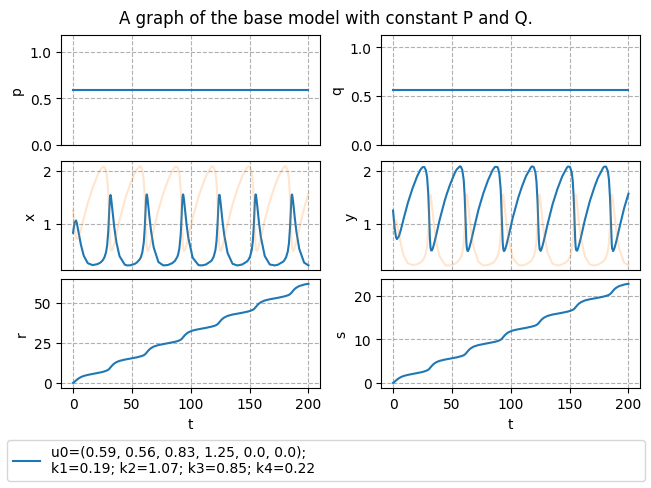

In [8]:
if success:
    visualize_simulation(u0_base, coeffs_base, time_bound_base, time_resolution_base,
                         iter_total_base, u0_list, coeffs_list, sol_list)
else:
    print("simulation failed. Stopping and printing failed settings.")
    print(u0_list, "\n", coeffs_list)